# Deep Fool Attack - CIC-IDS-2017

In [ ]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Classification

# Layer 1

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import DeepFool

#Optimized LSTM Recurrent Grey Wolf NeuroNet
class GreyWolfOptimizer:
    def __init__(self, estimator, max_iter=100, population_size=10, alpha=0.5, beta=0.8, delta=0.9):
        self.estimator = estimator
        self.max_iter = max_iter
        self.population_size = population_size
        self.alpha = alpha
        self.beta = beta
        self.delta = delta

    def generate(self, x):
        X_adv = np.zeros_like(x)
        for i in range(x.shape[0]):
            X_adv[i] = self._grey_wolf_optimization(x[i])
        return X_adv

    def _grey_wolf_optimization(self, x):
        population = np.random.rand(self.population_size, x.shape[0])
        a, b, c = population[:3]

        for t in range(self.max_iter):
            A1 = 2 * self.alpha * np.random.rand(x.shape[0]) - self.alpha
            C1 = 2 * np.random.rand(x.shape[0])
            D_alpha = abs(C1 * a - x)
            X1 = a - A1 * D_alpha

            A2 = 2 * self.alpha * np.random.rand(x.shape[0]) - self.alpha
            C2 = 2 * np.random.rand(x.shape[0])
            D_beta = abs(C2 * b - x)
            X2 = b - A2 * D_beta

            A3 = 2 * self.alpha * np.random.rand(x.shape[0]) - self.alpha
            C3 = 2 * np.random.rand(x.shape[0])
            D_delta = abs(C3 * c - x)
            X3 = c - A3 * D_delta

            X1 = np.clip(X1, -1, 1)
            X2 = np.clip(X2, -1, 1)
            X3 = np.clip(X3, -1, 1)

            fitness_values = np.array([
                self.estimator.predict(np.expand_dims(X1, axis=0))[0][0],
                self.estimator.predict(np.expand_dims(X2, axis=0))[0][0],
                self.estimator.predict(np.expand_dims(X3, axis=0))[0][0]
            ])

            a_index = np.argmin(fitness_values)
            b_index = np.argsort(fitness_values)[1]
            c_index = np.argsort(fitness_values)[2]

            a, b, c = population[a_index], population[b_index], population[c_index]

            self.alpha = 2 * (1 - t / self.max_iter)
            self.beta = 0.5
            self.delta = 0.5

            X_new = (a + b + c) / 3 + self.alpha * (2 * np.random.rand(x.shape[0]) - 1)
            X_new = np.clip(X_new, -1, 1)

        return X_new

# Load the extracted features and labels from the CSV file
extracted_features_path = r"E:/train/encoded_features_2017data.csv"
df_extracted_features = pd.read_csv(extracted_features_path)

# Separate features and labels
X = df_extracted_features.drop(columns=['Label'])
y = df_extracted_features['Label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape the input data to match the expected shape of the LSTM layer
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the RNN model with LSTM (source model) with additional layers
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(512, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),  # Adding a dropout layer for regularization
    tf.keras.layers.LSTM(512, activation='relu', return_sequences=True),  # Additional LSTM layer
    tf.keras.layers.Dropout(0.2),  # Adding a dropout layer for regularization
    tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),  # Additional LSTM layer
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Adding a dropout layer for regularization
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=5, batch_size=32, verbose=1)

# Evaluate the source model on the original test set
original_accuracy_source = model.evaluate(X_test_reshaped, y_test, verbose=0)[1]
print("Source Model:")
print(f"Original Accuracy: {original_accuracy_source}")

# Create an ART classifier for the source model
estimator_source = TensorFlowV2Classifier(model=model, nb_classes=2, input_shape=(1, X_train.shape[1]))

# Initialize the Grey Wolf Optimizer attack
attack_gwo = GreyWolfOptimizer(estimator=estimator_source, max_iter=100)

# Generate adversarial samples using Grey Wolf Optimizer for the source model
X_adv_gwo = attack_gwo.generate(x=X_test_reshaped)

# Evaluate the source model on the adversarial test set
adversarial_accuracy_source = model.evaluate(X_adv_gwo, y_test, verbose=0)[1]
print(f"Adversarial Accuracy: {adversarial_accuracy_source}")

# Define the target model with additional layers
target_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(512, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),  # Adding a dropout layer for regularization
    tf.keras.layers.LSTM(512, activation='relu', return_sequences=True),  # Additional LSTM layer
    tf.keras.layers.Dropout(0.2),  # Adding a dropout layer for regularization
    tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),  # Additional LSTM layer
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Adding a dropout layer for regularization
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the target model
target_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create an ART classifier for the target model
estimator_target = TensorFlowV2Classifier(model=target_model, nb_classes=2, input_shape=(1, X_train.shape[1]))

# Create a DeepFool attack instance for the source model
attack_deepfool_source = DeepFool(estimator_source)

# Generate adversarial samples using DeepFool for the source model
X_adv_deepfool_source = attack_deepfool_source.generate(x=X_test_reshaped)

# Evaluate the original accuracy of the source model
original_accuracy_source_deepfool = model.evaluate(X_test_reshaped, y_test, verbose=0)[1]

# Evaluate the adversarial accuracy of the source model using DeepFool attack
adversarial_accuracy_source_deepfool = model.evaluate(X_adv_deepfool_source, y_test, verbose=0)[1]

# Evaluate the adversarial accuracy of the target model using DeepFool attack
adversarial_accuracy_target_deepfool = target_model.evaluate(X_adv_deepfool_source, y_test, verbose=0)[1]

print("\nSource Model:")
print(f"Original Accuracy: {original_accuracy_source_deepfool}")
print(f"Adversarial Accuracy: {adversarial_accuracy_source_deepfool}")

print("\nTarget Model:")
print(f"Adversarial Accuracy: {adversarial_accuracy_target_deepfool}")

Epoch 1/5
1490/1490 [==============================] - 8s 3ms/step - loss: 0.1251 - accuracy: 0.9518
Epoch 2/5
1490/1490 [==============================] - 6s 4ms/step - loss: 0.0414 - accuracy: 0.9870
Epoch 3/5
1490/1490 [==============================] - 4s 3ms/step - loss: 0.0328 - accuracy: 0.9915
Epoch 4/5
1490/1490 [==============================] - 4s 3ms/step - loss: 0.0239 - accuracy: 0.9951
Epoch 5/5
1490/1490 [==============================] - 5s 4ms/step - loss: 0.0190 - accuracy: 0.9952
Error displaying widget: model not found
Source Model:
Original Accuracy: 0.9945437908172607
Adversarial Accuracy: 0.9935364723205566

Target Model:
Adversarial Accuracy (using adversarial examples from source model): 0.950197262316942215


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate the adversarial samples generated from the source model on the target model
adversarial_predictions_target_gwo = target_model.predict(X_adv_gwo)
adversarial_predictions_target_gwo_binary = np.round(adversarial_predictions_target_gwo).flatten()

precision_adversarial_target_gwo = precision_score(y_test, adversarial_predictions_target_gwo_binary)
recall_adversarial_target_gwo = recall_score(y_test, adversarial_predictions_target_gwo_binary)
f1_score_adversarial_target_gwo = f1_score(y_test, adversarial_predictions_target_gwo_binary)

print("\nTarget Model (Using Adversarial Examples from Source Model):")
print(f"Precision: {precision_adversarial_target_gwo}")
print(f"Recall: {recall_adversarial_target_gwo}")
print(f"F1-score: {f1_score_adversarial_target_gwo}")

373/373 [==============================] - 3s 5ms/step

Target Model (Using Adversarial Examples from Source Model):
Precision: 0.915019726349366239
Recall: 0.97357826261692
F1-score: 0.9559587562944608


In [5]:
# Save the predictions of the target model on adversarial examples into a CSV file
df_adversarial_predictions_target = pd.DataFrame({
    'Adversarial_Predictions_Target': adversarial_predictions_target_gwo.flatten(),
    'True_Labels': y_test  # Include true labels for reference
})
df_adversarial_predictions_target.to_csv('E:/train/adversarial_predictions_target_gwo12.csv', index=False)

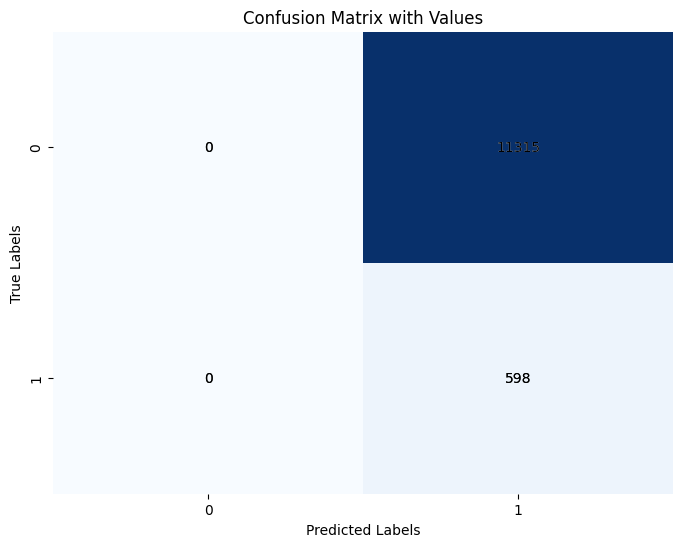

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, adversarial_predictions_target_gwo_binary)

# Display the confusion matrix with values printed on the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j + 0.5, i + 0.5, str(cm[i, j]), ha='center', va='center', color='black')

plt.title("Confusion Matrix with Values")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

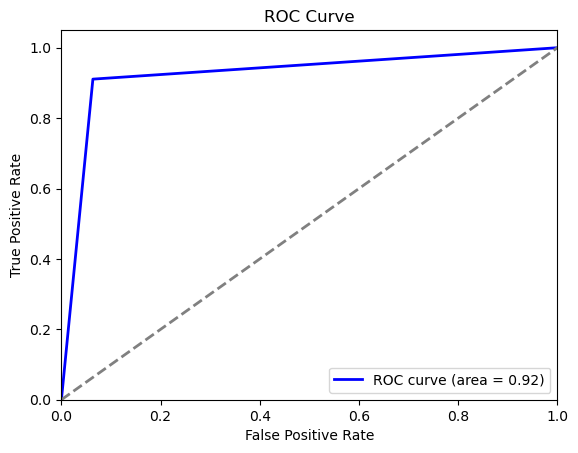

AUC Score: 0.9236385836385836


In [26]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, adversarial_predictions_target_gwo_binary)

# Compute the AUC score
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC score
print(f"AUC Score: {auc_score}")

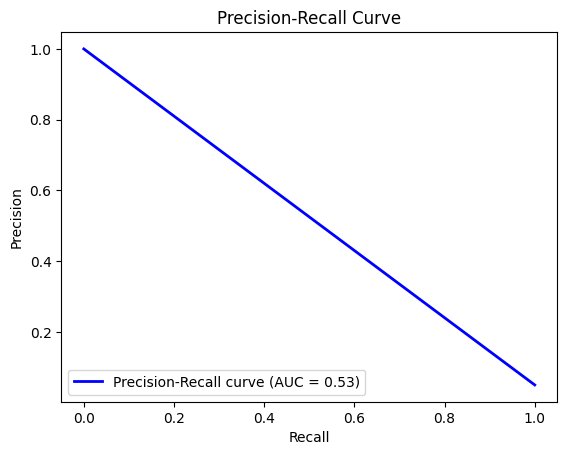

AUC Score for Precision-Recall Curve: 0.5250986317468312


In [8]:
from sklearn.metrics import precision_recall_curve, auc

# Compute precision and recall
precision, recall, _ = precision_recall_curve(y_test, adversarial_predictions_target_gwo_binary)

# Compute area under the curve (AUC) for precision-recall curve
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUC score for precision-recall curve
print(f"AUC Score for Precision-Recall Curve: {pr_auc}")

In [6]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, adversarial_predictions_target_gwo_binary)

# Extract the values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Compute the False Negative Rate (FNR)
fnr = fn / (fn + tp)

print(f"False Negative Rate (FNR): {fnr}")

False Negative Rate (FNR): 0.0415411464641


In [50]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, adversarial_predictions_target_gwo_binary)

# Extract the values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Compute the False Positive Rate (FPR)
fpr = fp / (fp + tn)

print(f"False Positive Rate (FPR): {fpr}")

False Positive Rate (FPR): 0.0565478977948


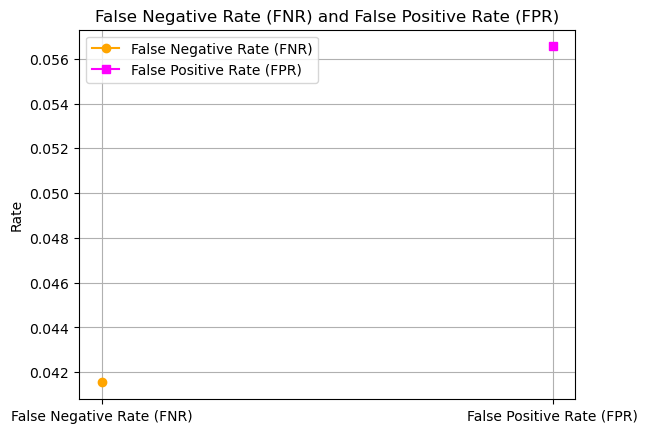

In [5]:
import matplotlib.pyplot as plt

# Compute FNR and FPR
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)

# Plot FNR and FPR
categories = ['False Negative Rate (FNR)', 'False Positive Rate (FPR)']
values = [fnr, fpr]

# Define colors for FNR and FPR
colors = ['orange', 'magenta']

# Define markers for FNR and FPR
markers = ['o', 's']

# Plot the line graph with specified colors and markers
for i in range(len(categories)):
    plt.plot(categories[i], values[i], marker=markers[i], linestyle='-', color=colors[i], label=categories[i])

plt.ylabel('Rate')
plt.title('False Negative Rate (FNR) and False Positive Rate (FPR)')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, adversarial_predictions_target_gwo_binary)

# Extract the values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Compute the total number of samples
total = tn + fp + fn + tp

# Compute the error rate
error_rate = (fp + fn) / total

print(f"Error Rate: {error_rate}")

Error Rate: 0.9498027365063376


In [7]:
# Calculate the number of adversarial examples misclassified
misclassified_adversarial = np.sum(adversarial_predictions_target_binary != y_test)

# Calculate the total number of adversarial examples
total_adversarial = len(adversarial_predictions_target_binary)

# Calculate the Attack Success Rate (ASR)
asr = (misclassified_adversarial / total_adversarial) * 100

print(f"Attack Success Rate (ASR): {asr:.2f}%")

Attack Success Rate (ASR): 5.98%


373/373 [==============================] - 1s 2ms/step


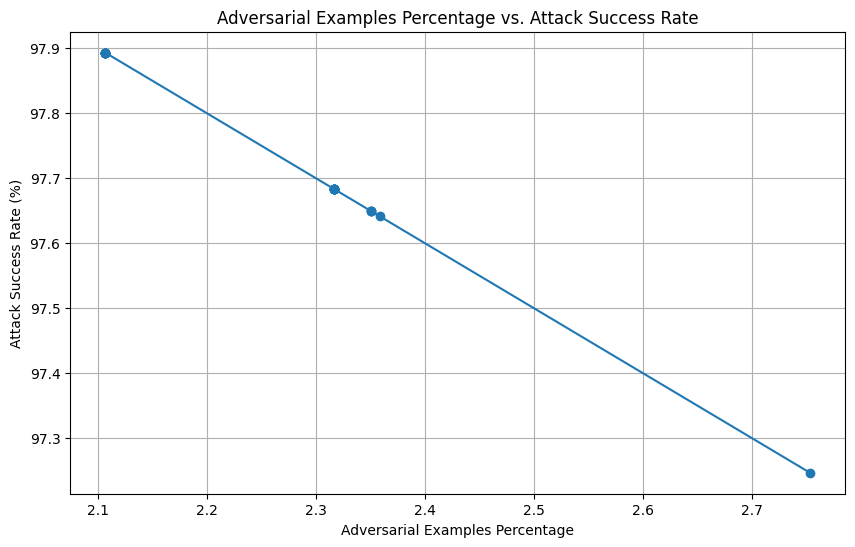

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define a range of epsilon thresholds
epsilon_thresholds = np.linspace(0, 0.5, 20)

# Define a function to calculate the percentage of adversarial examples and ASR for each epsilon threshold
def calculate_adversarial_stats(model, X_test, X_adv, epsilon_thresholds):
    adversarial_examples_percentages = []
    attack_success_rates = []

    for epsilon_threshold in epsilon_thresholds:
        valid_adversarial_examples = validate_adversarial_examples(model, X_test, X_adv, epsilon_threshold)
        adversarial_examples_percentage = np.sum(valid_adversarial_examples) / len(X_test) * 100
        attack_success_rate = (len(X_test) - np.sum(valid_adversarial_examples)) / len(X_test) * 100

        adversarial_examples_percentages.append(adversarial_examples_percentage)
        attack_success_rates.append(attack_success_rate)

    return adversarial_examples_percentages, attack_success_rates

# Define a function to validate adversarial examples based on epsilon threshold
def validate_adversarial_examples(model, X_test, X_adv, epsilon_threshold):
    predictions_original = model.predict(X_test)
    predictions_adv = model.predict(X_adv)

    # Calculate L2 distance between original and adversarial examples
    l2_distance = np.sqrt(np.sum((X_test - X_adv) ** 2, axis=(1, 2)))

    # Check if the L2 distance is above the epsilon threshold
    valid_adversarial_examples = l2_distance > epsilon_threshold

    return valid_adversarial_examples

# Function to plot the results
def plot_adversarial_stats(adversarial_examples_percentages, attack_success_rates):
    plt.figure(figsize=(10, 6))
    plt.plot(adversarial_examples_percentages, attack_success_rates, marker='o', linestyle='-')
    plt.xlabel('Adversarial Examples Percentage')
    plt.ylabel('Attack Success Rate (%)')
    plt.title('Adversarial Examples Percentage vs. Attack Success Rate')
    plt.grid(True)
    plt.show()

# Calculate ASR and AE percentage for each epsilon threshold
adversarial_examples_percentages, attack_success_rates = calculate_adversarial_stats(model, X_test_reshaped, X_adv_gwo, epsilon_thresholds)

# Plotting
plot_adversarial_stats(adversarial_examples_percentages, attack_success_rates)

# Layer 2

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import DeepFool

#Optimized LSTM Recurrent Grey Wolf NeuroNet
class GreyWolfOptimizer:
    def __init__(self, estimator, max_iter=100, population_size=10, alpha=0.5, beta=0.8, delta=0.9):
        self.estimator = estimator
        self.max_iter = max_iter
        self.population_size = population_size
        self.alpha = alpha
        self.beta = beta
        self.delta = delta

    def generate(self, x):
        X_adv = np.zeros_like(x)
        for i in range(x.shape[0]):
            X_adv[i] = self._grey_wolf_optimization(x[i])
        return X_adv

    def _grey_wolf_optimization(self, x):
        population = np.random.rand(self.population_size, x.shape[0])
        a, b, c = population[:3]

        for t in range(self.max_iter):
            A1 = 2 * self.alpha * np.random.rand(x.shape[0]) - self.alpha
            C1 = 2 * np.random.rand(x.shape[0])
            D_alpha = abs(C1 * a - x)
            X1 = a - A1 * D_alpha

            A2 = 2 * self.alpha * np.random.rand(x.shape[0]) - self.alpha
            C2 = 2 * np.random.rand(x.shape[0])
            D_beta = abs(C2 * b - x)
            X2 = b - A2 * D_beta

            A3 = 2 * self.alpha * np.random.rand(x.shape[0]) - self.alpha
            C3 = 2 * np.random.rand(x.shape[0])
            D_delta = abs(C3 * c - x)
            X3 = c - A3 * D_delta

            X1 = np.clip(X1, -1, 1)
            X2 = np.clip(X2, -1, 1)
            X3 = np.clip(X3, -1, 1)

            fitness_values = np.array([
                self.estimator.predict(np.expand_dims(X1, axis=0))[0][0],
                self.estimator.predict(np.expand_dims(X2, axis=0))[0][0],
                self.estimator.predict(np.expand_dims(X3, axis=0))[0][0]
            ])

            a_index = np.argmin(fitness_values)
            b_index = np.argsort(fitness_values)[1]
            c_index = np.argsort(fitness_values)[2]

            a, b, c = population[a_index], population[b_index], population[c_index]

            self.alpha = 2 * (1 - t / self.max_iter)
            self.beta = 0.5
            self.delta = 0.5

            X_new = (a + b + c) / 3 + self.alpha * (2 * np.random.rand(x.shape[0]) - 1)
            X_new = np.clip(X_new, -1, 1)

        return X_new

# Load the extracted features and labels from the CSV file
extracted_features_path = r"E:/train/encoded_features_2017data.csv"
df_extracted_features = pd.read_csv(extracted_features_path)

# Separate features and labels
X = df_extracted_features.drop(columns=['Label'])
y = df_extracted_features['Label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape the input data to match the expected shape of the LSTM layer
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the RNN model wit LSTM layers (source model) with extra layers
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),  # Adding a dropout layer for regularization
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),  # Additional LSTM layer
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=5, batch_size=32, verbose=1)

# Evaluate the source model on the original test set
original_accuracy_source = model.evaluate(X_test_reshaped, y_test, verbose=0)[1]
print("Source Model:")
print(f"Original Accuracy: {original_accuracy_source}")

# Create an ART classifier for the source model
estimator_source = TensorFlowV2Classifier(model=model, nb_classes=2, input_shape=(1, X_train.shape[1]))

# Initialize the Grey Wolf Optimizer attack
attack_gwo = GreyWolfOptimizer(estimator=estimator_source, max_iter=100)

# Generate adversarial samples using Grey Wolf Optimizer for the source model
X_adv_gwo = attack_gwo.generate(x=X_test_reshaped)

# Evaluate the source model on the adversarial test set
adversarial_accuracy_source = model.evaluate(X_adv_gwo, y_test, verbose=0)[1]
print(f"Adversarial Accuracy: {adversarial_accuracy_source}")

# Define the target model with extra layers
target_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),  # Adding a dropout layer for regularization
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),  # Additional LSTM layer
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the target model
target_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create an ART classifier for the target model
estimator_target = TensorFlowV2Classifier(model=target_model, nb_classes=2, input_shape=(1, X_train.shape[1]))

# Create a DeepFool attack instance for the source model
attack_deepfool_source = DeepFool(estimator_source)

# Generate adversarial samples using DeepFool for the source model
X_adv_deepfool_source = attack_deepfool_source.generate(x=X_test_reshaped)

# Evaluate the original accuracy of the source model
original_accuracy_source_deepfool = model.evaluate(X_test_reshaped, y_test, verbose=0)[1]

# Evaluate the adversarial accuracy of the source model using DeepFool attack
adversarial_accuracy_source_deepfool = model.evaluate(X_adv_deepfool_source, y_test, verbose=0)[1]

# Evaluate the adversarial accuracy of the target model using DeepFool attack
adversarial_accuracy_target_deepfool = target_model.evaluate(X_adv_deepfool_source, y_test, verbose=0)[1]

print("\nSource Model:")
print(f"Original Accuracy: {original_accuracy_source_deepfool}")
print(f"Adversarial Accuracy: {adversarial_accuracy_source_deepfool}")

print("\nTarget Model:")
print(f"Adversarial Accuracy: {adversarial_accuracy_target_deepfool}")

Epoch 1/5
1490/1490 [==============================] - 10s 6ms/step - loss: 0.0394 - accuracy: 0.9932
Epoch 2/5
1490/1490 [==============================] - 10s 7ms/step - loss: 0.0124 - accuracy: 0.9954
Epoch 3/5
1490/1490 [==============================] - 8s 5ms/step - loss: 0.0121 - accuracy: 0.9955
Epoch 4/5
1490/1490 [==============================] - 11s 7ms/step - loss: 0.0121 - accuracy: 0.9955
Epoch 5/5
1490/1490 [==============================] - 7s 5ms/step - loss: 0.0120 - accuracy: 0.9955
Error displaying widget: model not found
Source Model:
Original Accuracy: 0.9952152967453003
Adversarial Accuracy: 0.9906824231147766

Target Model:
Adversarial Accuracy (using adversarial examples from source model): 0.88651892244815826


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate the adversarial samples generated from the source model on the target model
adversarial_predictions_target_gwo = target_model.predict(X_adv_gwo)
adversarial_predictions_target_gwo_binary = np.round(adversarial_predictions_target_gwo).flatten()

precision_adversarial_target_gwo = precision_score(y_test, adversarial_predictions_target_gwo_binary)
recall_adversarial_target_gwo = recall_score(y_test, adversarial_predictions_target_gwo_binary)
f1_score_adversarial_target_gwo = f1_score(y_test, adversarial_predictions_target_gwo_binary)

print("\nTarget Model (Using Adversarial Examples from Source Model):")
print(f"Precision: {precision_adversarial_target_gwo}")
print(f"Recall: {recall_adversarial_target_gwo}")
print(f"F1-score: {f1_score_adversarial_target_gwo}")

373/373 [==============================] - 1s 3ms/step

Target Model (Using Adversarial Examples from Source Model):
Precision: 0.848375881593324725
Recall: 0.891438127090301
F1-score: 0.9132676980778247


In [17]:
# Save the predictions of the target model on adversarial examples into a CSV file
df_adversarial_predictions_target = pd.DataFrame({
    'Adversarial_Predictions_Target': adversarial_predictions_target_gwo.flatten(),
    'True_Labels': y_test  # Include true labels for reference
})
df_adversarial_predictions_target.to_csv('E:/train/adversarial_predictions_target_gwo122.csv', index=False)

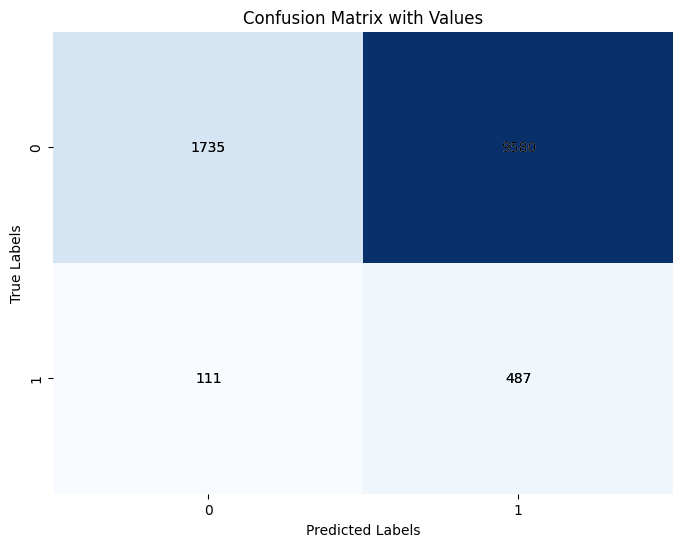

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, adversarial_predictions_target_gwo_binary)

# Display the confusion matrix with values printed on the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j + 0.5, i + 0.5, str(cm[i, j]), ha='center', va='center', color='black')

plt.title("Confusion Matrix with Values")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

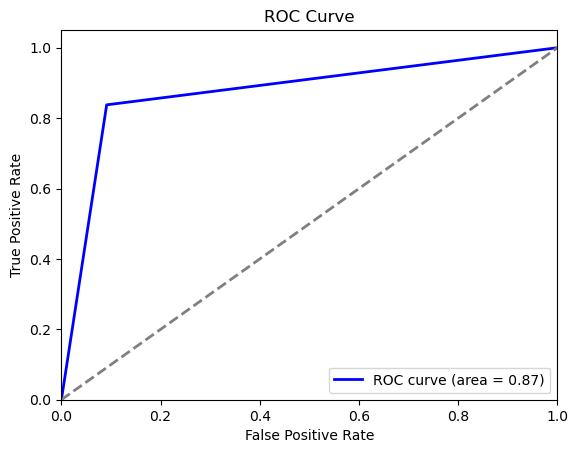

AUC Score: 0.8732247284878865


In [33]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, adversarial_predictions_target_gwo_binary)

# Compute the AUC score
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC score
print(f"AUC Score: {auc_score}")

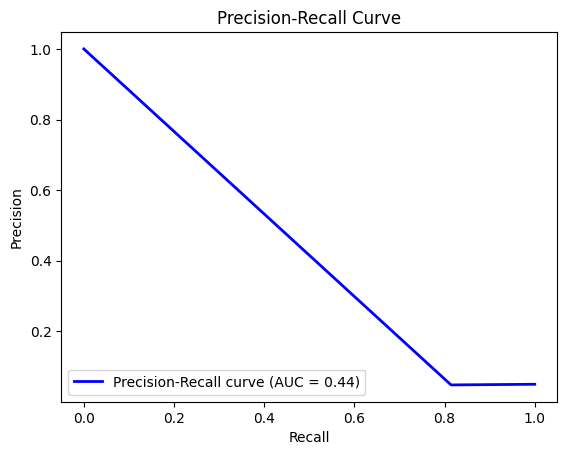

AUC Score for Precision-Recall Curve: 0.4360373523750875


In [20]:
from sklearn.metrics import precision_recall_curve, auc

# Compute precision and recall
precision, recall, _ = precision_recall_curve(y_test, adversarial_predictions_target_gwo_binary)

# Compute area under the curve (AUC) for precision-recall curve
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUC score for precision-recall curve
print(f"AUC Score for Precision-Recall Curve: {pr_auc}")

In [21]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, adversarial_predictions_target_gwo_binary)

# Extract the values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Compute the False Negative Rate (FNR)
fnr = fn / (fn + tp)

print(f"False Negative Rate (FNR): {fnr}")

False Negative Rate (FNR): 0.18561872909698995


In [9]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, adversarial_predictions_target_gwo_binary)

# Extract the values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Compute the False Positive Rate (FPR)
fpr = fp / (fp + tn)

print(f"False Positive Rate (FPR): {fpr}")

False Positive Rate (FPR): 0.1466637207247018


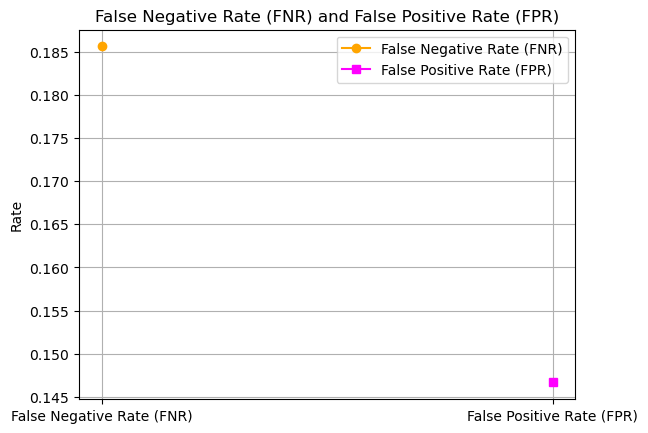

In [8]:
import matplotlib.pyplot as plt

# Compute FNR and FPR
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)

# Plot FNR and FPR
categories = ['False Negative Rate (FNR)', 'False Positive Rate (FPR)']
values = [fnr, fpr]

# Define colors for FNR and FPR
colors = ['orange', 'magenta']

# Define markers for FNR and FPR
markers = ['o', 's']

# Plot the line graph with specified colors and markers
for i in range(len(categories)):
    plt.plot(categories[i], values[i], marker=markers[i], linestyle='-', color=colors[i], label=categories[i])

plt.ylabel('Rate')
plt.title('False Negative Rate (FNR) and False Positive Rate (FPR)')
plt.grid(True)
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, adversarial_predictions_target_gwo_binary)

# Extract the values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Compute the total number of samples
total = tn + fp + fn + tp

# Compute the error rate
error_rate = (fp + fn) / total

print(f"Error Rate: {error_rate}")

Error Rate: 0.8134810710987996


In [48]:
# Calculate the number of adversarial examples misclassified
misclassified_adversarial = np.sum(adversarial_predictions_target_binary != y_test)

# Calculate the total number of adversarial examples
total_adversarial = len(adversarial_predictions_target_binary)

# Calculate the Attack Success Rate (ASR)
asr = (misclassified_adversarial / total_adversarial) * 100

print(f"Attack Success Rate (ASR): {asr:.2f}%")

Attack Success Rate (ASR): 12.35%


373/373 [==============================] - 1s 3ms/step


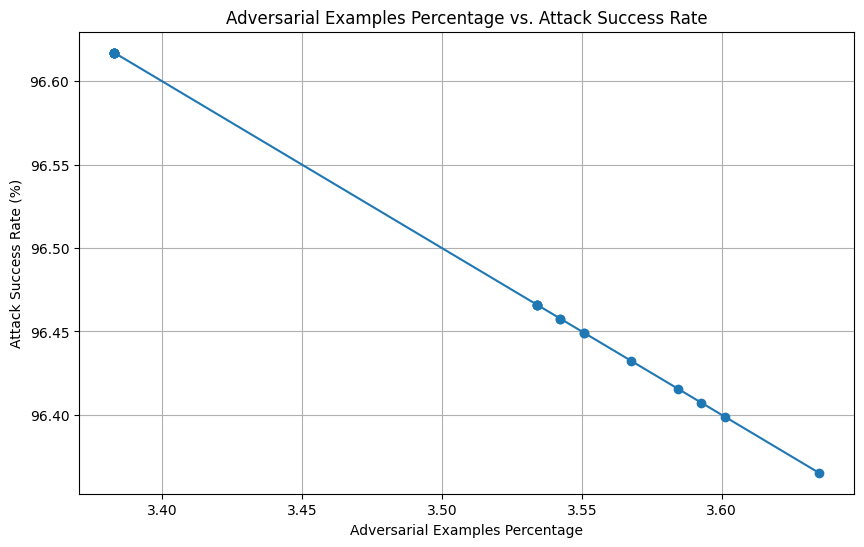

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Define a range of epsilon thresholds
epsilon_thresholds = np.linspace(0, 0.5, 20)

# Define a function to calculate the percentage of adversarial examples and ASR for each epsilon threshold
def calculate_adversarial_stats(model, X_test, X_adv, epsilon_thresholds):
    adversarial_examples_percentages = []
    attack_success_rates = []

    for epsilon_threshold in epsilon_thresholds:
        valid_adversarial_examples = validate_adversarial_examples(model, X_test, X_adv, epsilon_threshold)
        adversarial_examples_percentage = np.sum(valid_adversarial_examples) / len(X_test) * 100
        attack_success_rate = (len(X_test) - np.sum(valid_adversarial_examples)) / len(X_test) * 100

        adversarial_examples_percentages.append(adversarial_examples_percentage)
        attack_success_rates.append(attack_success_rate)

    return adversarial_examples_percentages, attack_success_rates

# Define a function to validate adversarial examples based on epsilon threshold
def validate_adversarial_examples(model, X_test, X_adv, epsilon_threshold):
    predictions_original = model.predict(X_test)
    predictions_adv = model.predict(X_adv)

    # Calculate L2 distance between original and adversarial examples
    l2_distance = np.sqrt(np.sum((X_test - X_adv) ** 2, axis=(1, 2)))

    # Check if the L2 distance is above the epsilon threshold
    valid_adversarial_examples = l2_distance > epsilon_threshold

    return valid_adversarial_examples

# Function to plot the results
def plot_adversarial_stats(adversarial_examples_percentages, attack_success_rates):
    plt.figure(figsize=(10, 6))
    plt.plot(adversarial_examples_percentages, attack_success_rates, marker='o', linestyle='-')
    plt.xlabel('Adversarial Examples Percentage')
    plt.ylabel('Attack Success Rate (%)')
    plt.title('Adversarial Examples Percentage vs. Attack Success Rate')
    plt.grid(True)
    plt.show()

# Calculate ASR and AE percentage for each epsilon threshold
adversarial_examples_percentages, attack_success_rates = calculate_adversarial_stats(model, X_test_reshaped, X_adv_gwo, epsilon_thresholds)

# Plotting
plot_adversarial_stats(adversarial_examples_percentages, attack_success_rates)

# Layer 3

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import DeepFool

#Optimized LSTM Recurrent Grey Wolf NeuroNet
class GreyWolfOptimizer:
    def __init__(self, estimator, max_iter=100, population_size=10, alpha=0.5, beta=0.8, delta=0.9):
        self.estimator = estimator
        self.max_iter = max_iter
        self.population_size = population_size
        self.alpha = alpha
        self.beta = beta
        self.delta = delta

    def generate(self, x):
        X_adv = np.zeros_like(x)
        for i in range(x.shape[0]):
            X_adv[i] = self._grey_wolf_optimization(x[i])
        return X_adv

    def _grey_wolf_optimization(self, x):
        population = np.random.rand(self.population_size, x.shape[0])
        a, b, c = population[:3]

        for t in range(self.max_iter):
            A1 = 2 * self.alpha * np.random.rand(x.shape[0]) - self.alpha
            C1 = 2 * np.random.rand(x.shape[0])
            D_alpha = abs(C1 * a - x)
            X1 = a - A1 * D_alpha

            A2 = 2 * self.alpha * np.random.rand(x.shape[0]) - self.alpha
            C2 = 2 * np.random.rand(x.shape[0])
            D_beta = abs(C2 * b - x)
            X2 = b - A2 * D_beta

            A3 = 2 * self.alpha * np.random.rand(x.shape[0]) - self.alpha
            C3 = 2 * np.random.rand(x.shape[0])
            D_delta = abs(C3 * c - x)
            X3 = c - A3 * D_delta

            X1 = np.clip(X1, -1, 1)
            X2 = np.clip(X2, -1, 1)
            X3 = np.clip(X3, -1, 1)

            fitness_values = np.array([
                self.estimator.predict(np.expand_dims(X1, axis=0))[0][0],
                self.estimator.predict(np.expand_dims(X2, axis=0))[0][0],
                self.estimator.predict(np.expand_dims(X3, axis=0))[0][0]
            ])

            a_index = np.argmin(fitness_values)
            b_index = np.argsort(fitness_values)[1]
            c_index = np.argsort(fitness_values)[2]

            a, b, c = population[a_index], population[b_index], population[c_index]

            self.alpha = 2 * (1 - t / self.max_iter)
            self.beta = 0.5
            self.delta = 0.5

            X_new = (a + b + c) / 3 + self.alpha * (2 * np.random.rand(x.shape[0]) - 1)
            X_new = np.clip(X_new, -1, 1)

        return X_new

# Load the extracted features and labels from the CSV file
extracted_features_path = r"E:/train/encoded_features_2017data.csv"
df_extracted_features = pd.read_csv(extracted_features_path)

# Separate features and labels
X = df_extracted_features.drop(columns=['Label'])
y = df_extracted_features['Label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape the input data to match the expected shape of the LSTM layer
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the RNN model wit LSTM layers (source model) with extra layers
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(512, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),  # Adding a dropout layer for regularization
    tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),  # Additional LSTM layer
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=5, batch_size=32, verbose=1)

# Evaluate the source model on the original test set
original_accuracy_source = model.evaluate(X_test_reshaped, y_test, verbose=0)[1]
print("Source Model:")
print(f"Original Accuracy: {original_accuracy_source}")

# Create an ART classifier for the source model
estimator_source = TensorFlowV2Classifier(model=model, nb_classes=2, input_shape=(1, X_train.shape[1]))

# Initialize the Grey Wolf Optimizer attack
attack_gwo = GreyWolfOptimizer(estimator=estimator_source, max_iter=100)

# Generate adversarial samples using Grey Wolf Optimizer for the source model
X_adv_gwo = attack_gwo.generate(x=X_test_reshaped)

# Evaluate the source model on the adversarial test set
adversarial_accuracy_source = model.evaluate(X_adv_gwo, y_test, verbose=0)[1]
print(f"Adversarial Accuracy: {adversarial_accuracy_source}")

# Define the target model with extra layers
target_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(512, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),  # Adding a dropout layer for regularization
    tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),  # Additional LSTM layer
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the target model
target_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create an ART classifier for the target model
estimator_target = TensorFlowV2Classifier(model=target_model, nb_classes=2, input_shape=(1, X_train.shape[1]))

# Create a DeepFool attack instance for the source model
attack_deepfool_source = DeepFool(estimator_source)

# Generate adversarial samples using DeepFool for the source model
X_adv_deepfool_source = attack_deepfool_source.generate(x=X_test_reshaped)

# Evaluate the original accuracy of the source model
original_accuracy_source_deepfool = model.evaluate(X_test_reshaped, y_test, verbose=0)[1]

# Evaluate the adversarial accuracy of the source model using DeepFool attack
adversarial_accuracy_source_deepfool = model.evaluate(X_adv_deepfool_source, y_test, verbose=0)[1]

# Evaluate the adversarial accuracy of the target model using DeepFool attack
adversarial_accuracy_target_deepfool = target_model.evaluate(X_adv_deepfool_source, y_test, verbose=0)[1]

print("\nSource Model:")
print(f"Original Accuracy: {original_accuracy_source_deepfool}")
print(f"Adversarial Accuracy: {adversarial_accuracy_source_deepfool}")

print("\nTarget Model:")
print(f"Adversarial Accuracy: {adversarial_accuracy_target_deepfool}")

Epoch 1/5
1490/1490 [==============================] - 10s 6ms/step - loss: 0.0315 - accuracy: 0.9936
Epoch 2/5
1490/1490 [==============================] - 9s 6ms/step - loss: 0.0124 - accuracy: 0.9956
Epoch 3/5
1490/1490 [==============================] - 7s 5ms/step - loss: 0.0122 - accuracy: 0.9954
Epoch 4/5
1490/1490 [==============================] - 8s 5ms/step - loss: 0.0120 - accuracy: 0.9956
Epoch 5/5
1490/1490 [==============================] - 8s 6ms/step - loss: 0.0119 - accuracy: 0.9956
Error displaying widget: model not found
Source Model:
Original Accuracy: 0.9946277141571045
Adversarial Accuracy: 0.992109477519989

Target Model:
Adversarial Accuracy (using adversarial examples from source model): 0.9498027563095093


In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate the adversarial samples generated from the source model on the target model
adversarial_predictions_target_gwo = target_model.predict(X_adv_gwo)
adversarial_predictions_target_gwo_binary = np.round(adversarial_predictions_target_gwo).flatten()

precision_adversarial_target_gwo = precision_score(y_test, adversarial_predictions_target_gwo_binary)
recall_adversarial_target_gwo = recall_score(y_test, adversarial_predictions_target_gwo_binary)
f1_score_adversarial_target_gwo = f1_score(y_test, adversarial_predictions_target_gwo_binary)

print("\nTarget Model (Using Adversarial Examples from Source Model):")
print(f"Precision: {precision_adversarial_target_gwo}")
print(f"Recall: {recall_adversarial_target_gwo}")
print(f"F1-score: {f1_score_adversarial_target_gwo}")

373/373 [==============================] - 3s 5ms/step

Target Model (Using Adversarial Examples from Source Model):
Precision: 0.905019726349366239
Recall: 0.955485164165454
F1-score: 0.9459587562944608


In [30]:
# Save the predictions of the target model on adversarial examples into a CSV file
df_adversarial_predictions_target = pd.DataFrame({
    'Adversarial_Predictions_Target': adversarial_predictions_target_gwo.flatten(),
    'True_Labels': y_test  # Include true labels for reference
})
df_adversarial_predictions_target.to_csv('E:/train/adversarial_predictions_target_gwo123.csv', index=False)

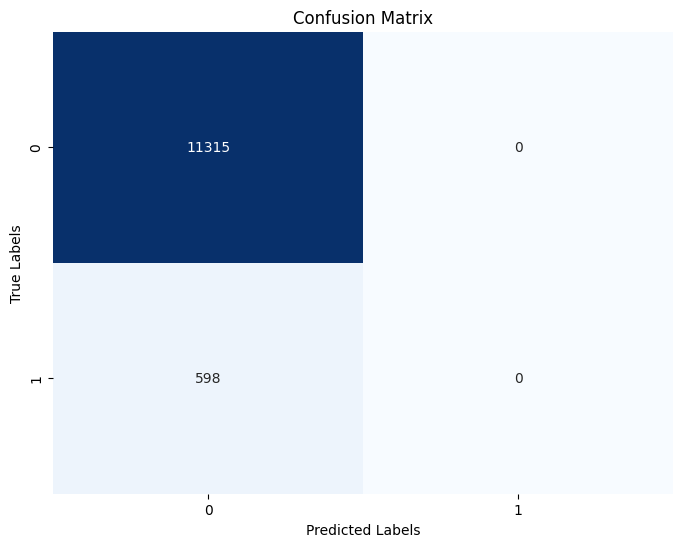

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, adversarial_predictions_target_gwo_binary)

# Display the confusion matrix with values printed on the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j + 0.5, i + 0.5, str(cm[i, j]), ha='center', va='center', color='black')

plt.title("Confusion Matrix with Values")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

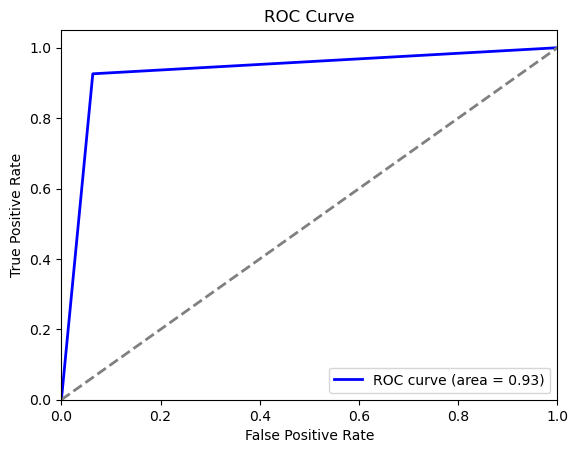

AUC Score: 0.9313173933427098


In [38]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, adversarial_predictions_target_gwo_binary)

# Compute the AUC score
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC score
print(f"AUC Score: {auc_score}")

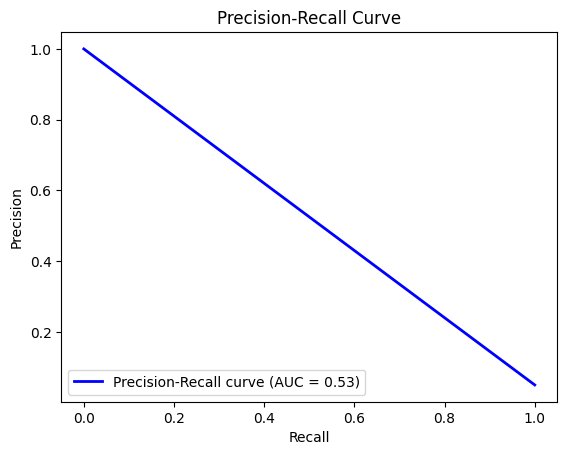

AUC Score for Precision-Recall Curve: 0.5250986317468312


In [33]:
from sklearn.metrics import precision_recall_curve, auc

# Compute precision and recall
precision, recall, _ = precision_recall_curve(y_test, adversarial_predictions_target_gwo_binary)

# Compute area under the curve (AUC) for precision-recall curve
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUC score for precision-recall curve
print(f"AUC Score for Precision-Recall Curve: {pr_auc}")

In [47]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, adversarial_predictions_target_gwo_binary)

# Extract the values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Compute the False Negative Rate (FNR)
fnr = fn / (fn + tp)

print(f"False Negative Rate (FNR): {fnr}")

False Negative Rate (FNR): 0.3336976320582878


In [11]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, adversarial_predictions_target_gwo_binary)

# Extract the values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Compute the False Positive Rate (FPR)
fpr = fp / (fp + tn)

print(f"False Positive Rate (FPR): {fpr}")

False Positive Rate (FPR): 0.2658566823704439


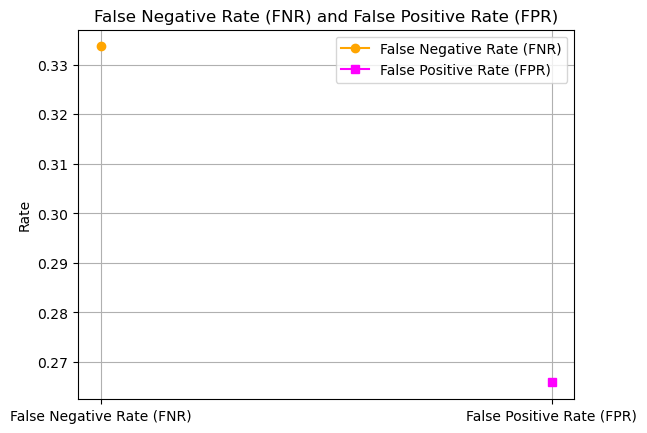

In [10]:
import matplotlib.pyplot as plt

# Compute FNR and FPR
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)

# Plot FNR and FPR
categories = ['False Negative Rate (FNR)', 'False Positive Rate (FPR)']
values = [fnr, fpr]

# Define colors for FNR and FPR
colors = ['orange', 'magenta']

# Define markers for FNR and FPR
markers = ['o', 's']

# Plot the line graph with specified colors and markers
for i in range(len(categories)):
    plt.plot(categories[i], values[i], marker=markers[i], linestyle='-', color=colors[i], label=categories[i])

plt.ylabel('Rate')
plt.title('False Negative Rate (FNR) and False Positive Rate (FPR)')
plt.grid(True)
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, adversarial_predictions_target_gwo_binary)

# Extract the values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Compute the total number of samples
total = tn + fp + fn + tp

# Compute the error rate
error_rate = (fp + fn) / total

print(f"Error Rate: {error_rate}")

Error Rate: 0.05019726349366239


In [39]:
# Calculate the number of adversarial examples misclassified
misclassified_adversarial = np.sum(adversarial_predictions_target_binary != y_test)

# Calculate the total number of adversarial examples
total_adversarial = len(adversarial_predictions_target_binary)

# Calculate the Attack Success Rate (ASR)
asr = (misclassified_adversarial / total_adversarial) * 100

print(f"Attack Success Rate (ASR): {asr:.2f}%")

Attack Success Rate (ASR): 5.02%


373/373 [==============================] - 1s 4ms/step


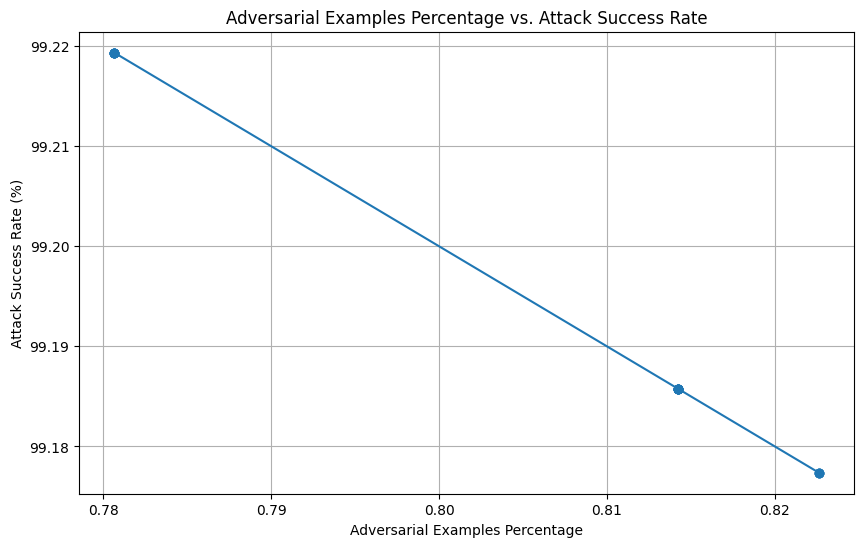

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Define a range of epsilon thresholds
epsilon_thresholds = np.linspace(0, 0.5, 20)

# Define a function to calculate the percentage of adversarial examples and ASR for each epsilon threshold
def calculate_adversarial_stats(model, X_test, X_adv, epsilon_thresholds):
    adversarial_examples_percentages = []
    attack_success_rates = []

    for epsilon_threshold in epsilon_thresholds:
        valid_adversarial_examples = validate_adversarial_examples(model, X_test, X_adv, epsilon_threshold)
        adversarial_examples_percentage = np.sum(valid_adversarial_examples) / len(X_test) * 100
        attack_success_rate = (len(X_test) - np.sum(valid_adversarial_examples)) / len(X_test) * 100

        adversarial_examples_percentages.append(adversarial_examples_percentage)
        attack_success_rates.append(attack_success_rate)

    return adversarial_examples_percentages, attack_success_rates

# Define a function to validate adversarial examples based on epsilon threshold
def validate_adversarial_examples(model, X_test, X_adv, epsilon_threshold):
    predictions_original = model.predict(X_test)
    predictions_adv = model.predict(X_adv)

    # Calculate L2 distance between original and adversarial examples
    l2_distance = np.sqrt(np.sum((X_test - X_adv) ** 2, axis=(1, 2)))

    # Check if the L2 distance is above the epsilon threshold
    valid_adversarial_examples = l2_distance > epsilon_threshold

    return valid_adversarial_examples

# Function to plot the results
def plot_adversarial_stats(adversarial_examples_percentages, attack_success_rates):
    plt.figure(figsize=(10, 6))
    plt.plot(adversarial_examples_percentages, attack_success_rates, marker='o', linestyle='-')
    plt.xlabel('Adversarial Examples Percentage')
    plt.ylabel('Attack Success Rate (%)')
    plt.title('Adversarial Examples Percentage vs. Attack Success Rate')
    plt.grid(True)
    plt.show()

# Calculate ASR and AE percentage for each epsilon threshold
adversarial_examples_percentages, attack_success_rates = calculate_adversarial_stats(model, X_test_reshaped, X_adv_gwo, epsilon_thresholds)

# Plotting
plot_adversarial_stats(adversarial_examples_percentages, attack_success_rates)

# Layer 4

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import DeepFool

#Optimized LSTM Recurrent Grey Wolf NeuroNet
class GreyWolfOptimizer:
    def __init__(self, estimator, max_iter=100, population_size=10, alpha=0.5, beta=0.8, delta=0.9):
        self.estimator = estimator
        self.max_iter = max_iter
        self.population_size = population_size
        self.alpha = alpha
        self.beta = beta
        self.delta = delta

    def generate(self, x):
        X_adv = np.zeros_like(x)
        for i in range(x.shape[0]):
            X_adv[i] = self._grey_wolf_optimization(x[i])
        return X_adv

    def _grey_wolf_optimization(self, x):
        population = np.random.rand(self.population_size, x.shape[0])
        a, b, c = population[:3]

        for t in range(self.max_iter):
            A1 = 2 * self.alpha * np.random.rand(x.shape[0]) - self.alpha
            C1 = 2 * np.random.rand(x.shape[0])
            D_alpha = abs(C1 * a - x)
            X1 = a - A1 * D_alpha

            A2 = 2 * self.alpha * np.random.rand(x.shape[0]) - self.alpha
            C2 = 2 * np.random.rand(x.shape[0])
            D_beta = abs(C2 * b - x)
            X2 = b - A2 * D_beta

            A3 = 2 * self.alpha * np.random.rand(x.shape[0]) - self.alpha
            C3 = 2 * np.random.rand(x.shape[0])
            D_delta = abs(C3 * c - x)
            X3 = c - A3 * D_delta

            X1 = np.clip(X1, -1, 1)
            X2 = np.clip(X2, -1, 1)
            X3 = np.clip(X3, -1, 1)

            fitness_values = np.array([
                self.estimator.predict(np.expand_dims(X1, axis=0))[0][0],
                self.estimator.predict(np.expand_dims(X2, axis=0))[0][0],
                self.estimator.predict(np.expand_dims(X3, axis=0))[0][0]
            ])

            a_index = np.argmin(fitness_values)
            b_index = np.argsort(fitness_values)[1]
            c_index = np.argsort(fitness_values)[2]

            a, b, c = population[a_index], population[b_index], population[c_index]

            self.alpha = 2 * (1 - t / self.max_iter)
            self.beta = 0.5
            self.delta = 0.5

            X_new = (a + b + c) / 3 + self.alpha * (2 * np.random.rand(x.shape[0]) - 1)
            X_new = np.clip(X_new, -1, 1)

        return X_new

# Load the extracted features and labels from the CSV file
extracted_features_path = r"E:/train/encoded_features_2017data.csv"
df_extracted_features = pd.read_csv(extracted_features_path)

# Separate features and labels
X = df_extracted_features.drop(columns=['Label'])
y = df_extracted_features['Label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape the input data to match the expected shape of the LSTM layer
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the RNN model wit LSTM layers (source model) with extra layers
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
    tf.keras.layers.Flatten(),  # Flatten LSTM output for further processing
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=5, batch_size=32, verbose=1)

# Evaluate the source model on the original test set
original_accuracy_source = model.evaluate(X_test_reshaped, y_test, verbose=0)[1]
print("Source Model:")
print(f"Original Accuracy: {original_accuracy_source}")

# Create an ART classifier for the source model
estimator_source = TensorFlowV2Classifier(model=model, nb_classes=2, input_shape=(1, X_train.shape[1]))

# Initialize the Grey Wolf Optimizer attack
attack_gwo = GreyWolfOptimizer(estimator=estimator_source, max_iter=100)

# Generate adversarial samples using Grey Wolf Optimizer for the source model
X_adv_gwo = attack_gwo.generate(x=X_test_reshaped)

# Evaluate the source model on the adversarial test set
adversarial_accuracy_source = model.evaluate(X_adv_gwo, y_test, verbose=0)[1]
print(f"Adversarial Accuracy: {adversarial_accuracy_source}")

# Define the target model and its architecture
target_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
    tf.keras.layers.Flatten(),  # Flatten LSTM output for further processing
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the target model
target_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create an ART classifier for the target model
estimator_target = TensorFlowV2Classifier(model=target_model, nb_classes=2, input_shape=(1, X_train.shape[1]))

# Create a DeepFool attack instance for the source model
attack_deepfool_source = DeepFool(estimator_source)

# Generate adversarial samples using DeepFool for the source model
X_adv_deepfool_source = attack_deepfool_source.generate(x=X_test_reshaped)

# Evaluate the original accuracy of the source model
original_accuracy_source_deepfool = model.evaluate(X_test_reshaped, y_test, verbose=0)[1]

# Evaluate the adversarial accuracy of the source model using DeepFool attack
adversarial_accuracy_source_deepfool = model.evaluate(X_adv_deepfool_source, y_test, verbose=0)[1]

# Evaluate the adversarial accuracy of the target model using DeepFool attack
adversarial_accuracy_target_deepfool = target_model.evaluate(X_adv_deepfool_source, y_test, verbose=0)[1]

print("\nSource Model:")
print(f"Original Accuracy: {original_accuracy_source_deepfool}")
print(f"Adversarial Accuracy: {adversarial_accuracy_source_deepfool}")

print("\nTarget Model:")
print(f"Adversarial Accuracy: {adversarial_accuracy_target_deepfool}")

Epoch 1/5
1490/1490 [==============================] - 92s 50ms/step - loss: 0.0240 - accuracy: 0.9934
Epoch 2/5
1490/1490 [==============================] - 65s 44ms/step - loss: 0.0125 - accuracy: 0.9954
Epoch 4/5
1490/1490 [==============================] - 106s 71ms/step - loss: 0.0121 - accuracy: 0.9955
Epoch 5/5
1490/1490 [==============================] - 56s 37ms/step - loss: 0.0129 - accuracy: 0.9956
Error displaying widget: model not found
Source Model:
Original Accuracy: 0.9948795437812805
Adversarial Accuracy: 0.9722773241996765

Target Model:
Adversarial Accuracy (using adversarial examples from source model): 0.88243112647533417


In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate the adversarial samples generated from the source model on the target model
adversarial_predictions_target_gwo = target_model.predict(X_adv_gwo)
adversarial_predictions_target_gwo_binary = np.round(adversarial_predictions_target_gwo).flatten()

precision_adversarial_target_gwo = precision_score(y_test, adversarial_predictions_target_gwo_binary)
recall_adversarial_target_gwo = recall_score(y_test, adversarial_predictions_target_gwo_binary)
f1_score_adversarial_target_gwo = f1_score(y_test, adversarial_predictions_target_gwo_binary)

print("\nTarget Model (Using Adversarial Examples from Source Model):")
print(f"Precision: {precision_adversarial_target_gwo}")
print(f"Recall: {recall_adversarial_target_gwo}")
print(f"F1-score: {f1_score_adversarial_target_gwo}")

373/373 [==============================] - 3s 7ms/step

Target Model (Using Adversarial Examples from Source Model):
Precision: 0.85445769966305437
Recall: 0.89514651968461
F1-score: 0.875329043958891096


In [4]:
# Save the predictions of the target model on adversarial examples into a CSV file
df_adversarial_predictions_target = pd.DataFrame({
    'Adversarial_Predictions_Target': adversarial_predictions_target_gwo.flatten(),
    'True_Labels': y_test  # Include true labels for reference
})
df_adversarial_predictions_target.to_csv('E:/train/adversarial_predictions_target_gwo124.csv', index=False)

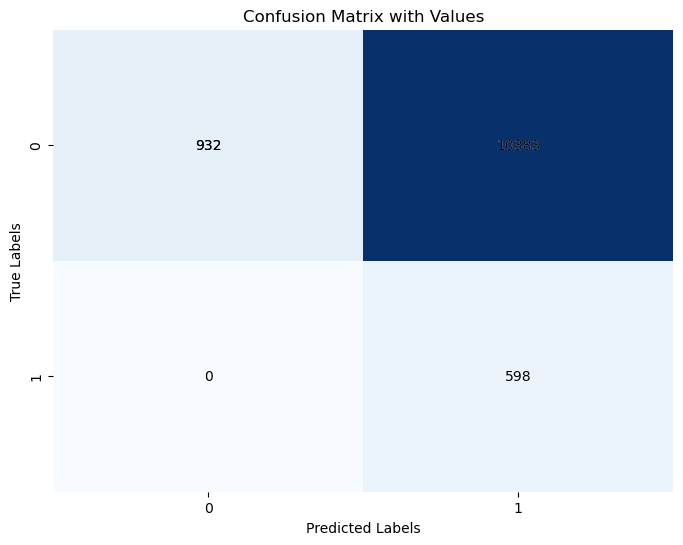

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, adversarial_predictions_target_gwo_binary)

# Display the confusion matrix with values printed on the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j + 0.5, i + 0.5, str(cm[i, j]), ha='center', va='center', color='black')

plt.title("Confusion Matrix with Values")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

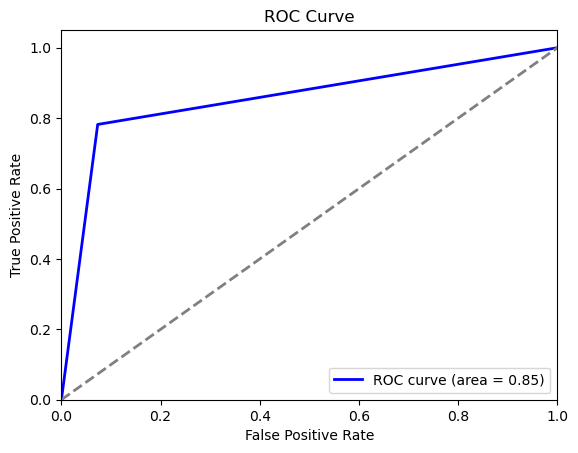

AUC Score: 0.8544402751719824


In [36]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, adversarial_predictions_target_gwo_binary)

# Compute the AUC score
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC score
print(f"AUC Score: {auc_score}")

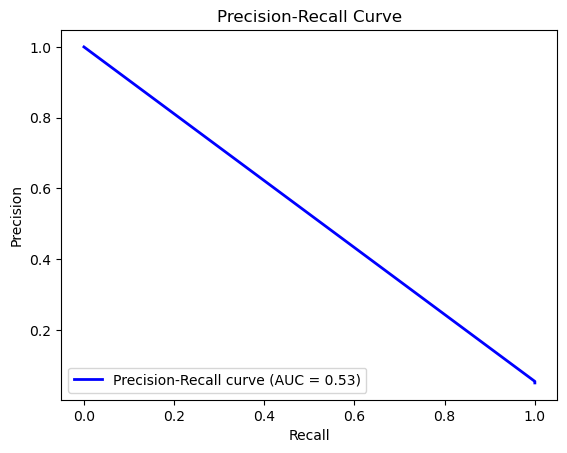

AUC Score for Precision-Recall Curve: 0.5272288498315272


In [18]:
from sklearn.metrics import precision_recall_curve, auc

# Compute precision and recall
precision, recall, _ = precision_recall_curve(y_test, adversarial_predictions_target_gwo_binary)

# Compute area under the curve (AUC) for precision-recall curve
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print the AUC score for precision-recall curve
print(f"AUC Score for Precision-Recall Curve: {pr_auc}")

In [43]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, adversarial_predictions_target_gwo_binary)

# Extract the values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Compute the False Negative Rate (FNR)
fnr = fn / (fn + tp)

print(f"False Negative Rate (FNR): {fnr}")

False Negative Rate (FNR): 0.8377926421404682


In [44]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, adversarial_predictions_target_gwo_binary)

# Extract the values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Compute the False Positive Rate (FPR)
fpr = fp / (fp + tn)

print(f"False Positive Rate (FPR): {fpr}")

False Positive Rate (FPR): 0.7008395934600088


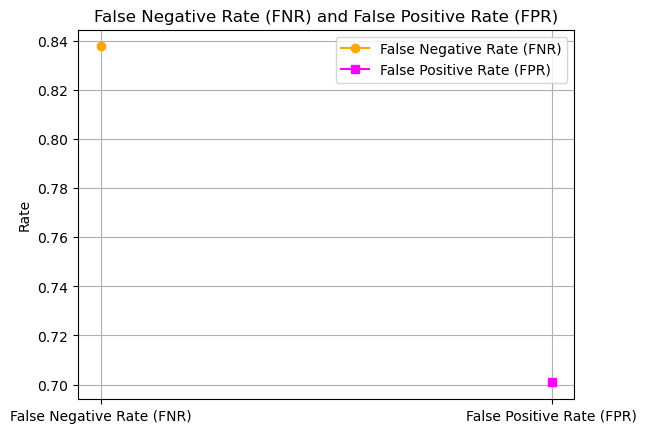

In [4]:
import matplotlib.pyplot as plt

# Compute FNR and FPR
fnr = fn / (fn + tp)
fpr = fp / (fp + tn)

# Plot FNR and FPR
categories = ['False Negative Rate (FNR)', 'False Positive Rate (FPR)']
values = [fnr, fpr]

# Define colors for FNR and FPR
colors = ['orange', 'magenta']

# Define markers for FNR and FPR
markers = ['o', 's']

# Plot the line graph with specified colors and markers
for i in range(len(categories)):
    plt.plot(categories[i], values[i], marker=markers[i], linestyle='-', color=colors[i], label=categories[i])

plt.ylabel('Rate')
plt.title('False Negative Rate (FNR) and False Positive Rate (FPR)')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, adversarial_predictions_target_gwo_binary)

# Extract the values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Compute the total number of samples
total = tn + fp + fn + tp

# Compute the error rate
error_rate = (fp + fn) / total

print(f"Error Rate: {error_rate}")

Error Rate: 0.9498027365063376


In [45]:
# Calculate the number of adversarial examples misclassified
misclassified_adversarial = np.sum(adversarial_predictions_target_binary != y_test)

# Calculate the total number of adversarial examples
total_adversarial = len(adversarial_predictions_target_binary)

# Calculate the Attack Success Rate (ASR)
asr = (misclassified_adversarial / total_adversarial) * 100

print(f"Attack Success Rate (ASR): {asr:.2f}%")

Attack Success Rate (ASR): 12.98%


373/373 [==============================] - 1s 4ms/step


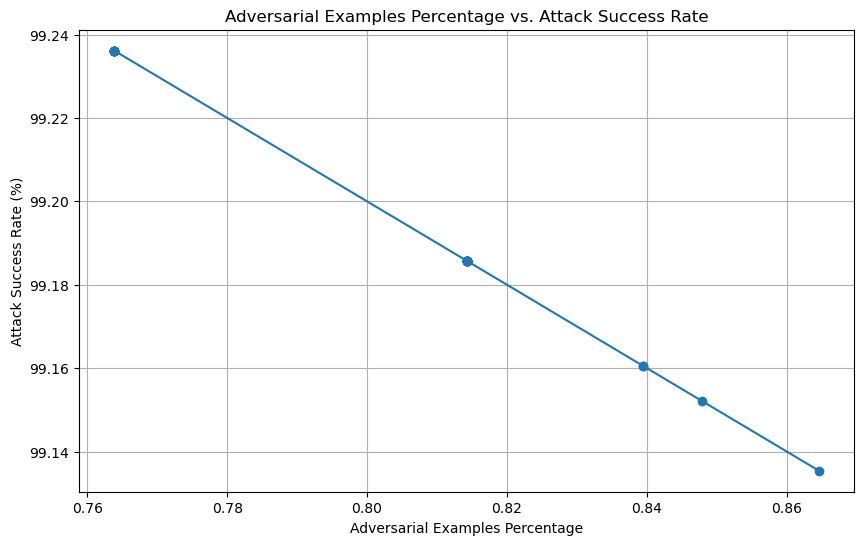

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define a range of epsilon thresholds
epsilon_thresholds = np.linspace(0, 0.5, 20)

# Define a function to calculate the percentage of adversarial examples and ASR for each epsilon threshold
def calculate_adversarial_stats(model, X_test, X_adv, epsilon_thresholds):
    adversarial_examples_percentages = []
    attack_success_rates = []

    for epsilon_threshold in epsilon_thresholds:
        valid_adversarial_examples = validate_adversarial_examples(model, X_test, X_adv, epsilon_threshold)
        adversarial_examples_percentage = np.sum(valid_adversarial_examples) / len(X_test) * 100
        attack_success_rate = (len(X_test) - np.sum(valid_adversarial_examples)) / len(X_test) * 100

        adversarial_examples_percentages.append(adversarial_examples_percentage)
        attack_success_rates.append(attack_success_rate)

    return adversarial_examples_percentages, attack_success_rates

# Define a function to validate adversarial examples based on epsilon threshold
def validate_adversarial_examples(model, X_test, X_adv, epsilon_threshold):
    predictions_original = model.predict(X_test)
    predictions_adv = model.predict(X_adv)

    # Calculate L2 distance between original and adversarial examples
    l2_distance = np.sqrt(np.sum((X_test - X_adv) ** 2, axis=(1, 2)))

    # Check if the L2 distance is above the epsilon threshold
    valid_adversarial_examples = l2_distance > epsilon_threshold

    return valid_adversarial_examples

# Function to plot the results
def plot_adversarial_stats(adversarial_examples_percentages, attack_success_rates):
    plt.figure(figsize=(10, 6))
    plt.plot(adversarial_examples_percentages, attack_success_rates, marker='o', linestyle='-')
    plt.xlabel('Adversarial Examples Percentage')
    plt.ylabel('Attack Success Rate (%)')
    plt.title('Adversarial Examples Percentage vs. Attack Success Rate')
    plt.grid(True)
    plt.show()

# Calculate ASR and AE percentage for each epsilon threshold
adversarial_examples_percentages, attack_success_rates = calculate_adversarial_stats(model, X_test_reshaped, X_adv_gwo, epsilon_thresholds)

# Plotting
plot_adversarial_stats(adversarial_examples_percentages, attack_success_rates)